# DeepMind Paper Implementation

- delete models
- huggingface-cli delete-cache


- https://github.com/shreyansh26/Speculative-Sampling

In [ ]:
import torch
from tqdm import tqdm
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import numpy as np
import time
from typing import Tuple
import pandas as pd
import matplotlib.pyplot as plt
import random
from transformers import set_seed
import os 
import dotenv



In [157]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")  
else:
    device = torch.device("cpu") 

print(f"Using device: {device}")

Using device: mps


In [158]:
torch.manual_seed(42)
random.seed(42)
set_seed(42)
np.random.seed(42)

In [159]:
import os
import dotenv
# dotenv.load_dotenv('/Users/vashisth/Desktop/research-new/speculative-decoding/.env')
dotenv.load_dotenv('/home/vashistt/research-new/speculative-decoding/.env')

hf_api = os.getenv('hf_api') 
print(os.getenv('hf_api') is not None)

True


In [160]:
def max_fn(x):
    x = x.to(device)  # Ensure x is on the correct device
    x_max = torch.where(x > 0, x, torch.tensor(0., device=device))
    x_max = x_max.float()
    sum_ = torch.sum(x_max, dim=-1, keepdim=True) + 1e-8
    x_max.div_(sum_)
    return x_max

In [161]:
def get_distribution(logits, temperature, epsilon=1e-8):
    logits = logits.to(device)  # Move logits to the device
    logits /= (temperature + epsilon)
    probability = F.softmax(logits, dim=-1)
    return probability.to(device)

In [162]:
def sample(logits, temperature):
    output = get_distribution(logits, temperature)
    output = torch.multinomial(output, num_samples=1)
    return output.squeeze(1)

In [172]:
def sample_from_draft_model(model, initial_prompt_seq, new_tokens, temperature=0):
    fin_prompt_seq = initial_prompt_seq.to(device)
    out_logits = []

    for _ in range(new_tokens):
        sample_token_logits = model(fin_prompt_seq).logits[:, -1, :]
        sample_token = sample(sample_token_logits, temperature=temperature)
        fin_prompt_seq = torch.cat([fin_prompt_seq, sample_token.unsqueeze(0)], dim=-1)
        out_logits.append(sample_token_logits)

    out_logits = torch.stack(out_logits, dim=1)
    return fin_prompt_seq, out_logits

In [164]:
def autoregressive_sampling(model, initial_prompt_seq, max_new_tokens, temperature=0):
    initial_prompt_seq = initial_prompt_seq.to(device)
    n = initial_prompt_seq.shape[-1]
    target_len = n + max_new_tokens
    fin_prompt_seq = initial_prompt_seq.detach().clone()

    while n < target_len:
        sample_token_logits = model(fin_prompt_seq).logits[:, -1, :]
        sample_token = sample(sample_token_logits, temperature=temperature)
        sample_token_unsqueezed = sample_token.unsqueeze(0)
        fin_prompt_seq = torch.cat([fin_prompt_seq, sample_token_unsqueezed], dim=-1)
        n += 1
    return fin_prompt_seq

In [165]:
def speculative_sampling(target_model, draft_model, initial_prompt_seq, max_new_tokens, tokenizer, lookahead=3, temperature=0, debug=True):
    
    # print(f"Initial device: {initial_prompt_seq.device}")  # Check initial device
    initial_prompt_seq = initial_prompt_seq.to(device)
    assert initial_prompt_seq.shape[0] == 1, 'Batch size should be 1'
    n = initial_prompt_seq.shape[-1]
    target_len = n + max_new_tokens
    fin_prompt_seq = initial_prompt_seq.detach().clone()

    while n < target_len:
        if debug:
            print('____________________')
            print('n: ', n)
        n_orig = n
        N = fin_prompt_seq.shape[-1]
        draft_model = draft_model.to(device)
        draft_outputs, draft_logits = sample_from_draft_model(draft_model, fin_prompt_seq, new_tokens=lookahead, temperature=temperature)
        
        # print(f"draft_outputs device after sample_from_draft_model: {draft_outputs.device}")  # Check device after sampling

        if debug:
            print(f"Possible continuations: {tokenizer.decode(draft_outputs[0, n_orig:], skip_special_tokens=True)}")

        draft_outputs = draft_outputs.to(device)
        # print(f"draft_outputs device before target_model: {draft_outputs.device}")  # Check device before passing to target_model
        
        # print('draft:', draft_outputs.device)
        
        # for param in target_model.parameters():
        #     print('target params', param.device)
        #     assert param.device == torch.device(device), "Model's parameter not on the correct device"
        target_model = target_model.to(device)
        
        target_logits = target_model(draft_outputs).logits[:, -lookahead-1:, :]
        # print(f"target_logits device: {target_logits.device}")  # Check device of target_logits

        target_model_distribution = get_distribution(target_logits, temperature).to(device)
        
        draft_model_distribution = get_distribution(draft_logits, temperature).to(device)
        
        # print(f"target_model_distribution device: {target_model_distribution.device}")  # Check device
        # print(f"draft_model_distribution device: {draft_model_distribution.device}")  # Check device

        accepted_flag = True

        for t in range(lookahead):
            numerator = target_model_distribution[:, t, draft_outputs[0, N+t]].to(device)
            denominator = draft_model_distribution[:, t, draft_outputs[0, N+t]].to(device)
            # print(f"Numerator and Denominator devices: {numerator.device}, {denominator.device}")  # Check devices

            ratio = (numerator / denominator)
            r = torch.rand_like(numerator, device = device)  # r inherits device from numerator
            ones_tensor = torch.ones_like(numerator)  # ones_tensor inherits device from numerator
            # No need to check r and ones_tensor devices since they inherit from numerator

            if (r < torch.min(ones_tensor, ratio)).any():
                fin_prompt_seq = torch.cat([fin_prompt_seq, draft_outputs[:, N+t].unsqueeze(dim=-1)], dim=-1)
                n += 1

                if debug:
                    accepted_token = tokenizer.decode(draft_outputs[0, N+t])
                    print(f"Accepted token: ''{accepted_token}'' ")

            else:
                new_dist = (target_model_distribution[:, t, :] - draft_model_distribution[:, t, :])
                new_dist = max_fn(new_dist).to(device)
                token_id = torch.multinomial(new_dist, num_samples=1)[0]
                fin_prompt_seq = torch.cat([fin_prompt_seq, token_id.unsqueeze(0)], dim=-1)

                accepted_flag = False

                if debug:
                    rejected_token = tokenizer.decode(draft_outputs[0, N+t])
                    new_token = tokenizer.decode(token_id)
                    print(f"Rejected token: ''{rejected_token}'', Replaced with: {new_token}")
                break

        if debug:
            full_sentence = tokenizer.decode(fin_prompt_seq[0], skip_special_tokens=True)
            print(f"Full sentence: {full_sentence}")

        if accepted_flag:
            sample_token = sample(target_logits[:, -1, :], temperature=temperature).to(device)
            fin_prompt_seq = torch.cat([fin_prompt_seq, sample_token.unsqueeze(0)], dim=-1)

        if debug:
            print(f"Accepted continuations: {tokenizer.decode(fin_prompt_seq[0, n_orig:], skip_special_tokens=True)}")

        n += 1

    return fin_prompt_seq

- GPT2: 124 M
- GPT-large: 774 M
- GPT-medium: 355M
- GPT-xl: 1.5B

In [166]:
# Model setup
draft_tokenizer = AutoTokenizer.from_pretrained("gpt2")  # 124M
draft_model = AutoModelForCausalLM.from_pretrained("gpt2").to(device)  # 124M
draft_generator = pipeline('text-generation', model=draft_model, tokenizer=draft_tokenizer)

In [168]:
# target_tokenizer = AutoTokenizer.from_pretrained("gpt2")  # 2* 774M parameter
# target_model = AutoModelForCausalLM.from_pretrained("gpt2").to(device)  # 2* 774M parameter
# target_generator = pipeline('text-generation', model=target_model, tokenizer=target_tokenizer)
# tokenizer = target_tokenizer

In [153]:
target_tokenizer = AutoTokenizer.from_pretrained("gpt2-xl")  # 2* 774M parameter
target_model = AutoModelForCausalLM.from_pretrained("gpt2-xl").to(device)  # 2* 774M parameter
target_model = target_model.to(device)
target_generator = pipeline('text-generation', model=target_model, tokenizer=target_tokenizer)
tokenizer = target_tokenizer

KeyboardInterrupt: 

In [169]:
question = 'The history of the United States of America is'

In [170]:
inputs = tokenizer(question, return_tensors="pt").to(device)

In [171]:
tokens = speculative_sampling(target_model, draft_model, initial_prompt_seq=inputs.input_ids, max_new_tokens= 20, lookahead=4, tokenizer=tokenizer, temperature=0., debug=True)

Initial device: mps:0
____________________
n:  4


RuntimeError: Placeholder storage has not been allocated on MPS device!

In [29]:
new_tokens = len(tokens[0]) - len(inputs.input_ids[0])
print(new_tokens)
print(tokenizer.decode(tokens[0]))

12
the quick brown foxes, and the black foxes, and the white fox


In [64]:
tokens = autoregressive_sampling(target_model, initial_prompt_seq=inputs.input_ids, max_new_tokens=11, temperature=0.)
new_tokens = len(tokens[0]) - len(inputs.input_ids[0])
print(new_tokens)
print(tokenizer.decode(tokens[0]))

RuntimeError: Placeholder storage has not been allocated on MPS device!

---

In [63]:
def sampling_test(prompt:str, tokenizer, sampling:str, target_model, draft_model=None, max_new_tokens=50, lookahead_k=2,temperature=0, debug= False)-> Tuple[str, float, int]:
   
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    # print('Given Input:', tokenizer.decode(tokenized_input[0],skip_special_tokens=True))

    if sampling == 'autoregressive':
        start = time.time()
        
        tokens = autoregressive_sampling(model = target_model , initial_prompt_seq=inputs.input_ids, max_new_tokens=max_new_tokens, temperature=temperature)
        
        end = time.time()
        
        generated_text = tokenizer.decode(tokens[0])
        
        num_new_tokens = len(tokens[0]) - len(inputs.input_ids[0])
        
        time_taken = end - start

    elif sampling == 'speculative':
        start = time.time()
        
        tokens = speculative_sampling(target_model, draft_model, initial_prompt_seq=inputs.input_ids, max_new_tokens=max_new_tokens, tokenizer= tokenizer, lookahead=lookahead_k, temperature=temperature, debug=debug)
        
        end = time.time()
        generated_text = tokenizer.decode(tokens[0])
        
        num_new_tokens = len(tokens[0]) - len(inputs.input_ids[0])

        time_taken = end - start
    
    else:
        raise ValueError('sampling must be either autoregressive or speculative')
    return generated_text, time_taken, num_new_tokens

In [35]:
prompt = 'United States in the year 2025'
temperature = 0
max_lengths = [16, 64, 128, 256]  # example max_lengths
lookahead_ks = [1, 2, 3, 4, 5, 7, 8]  # exaample lookahead_ks

# Store the results
results = []

# Loop over different max_length and k values
for max_length in max_lengths:
    # Run autoregressive sampling
    output_ar, time_ar, new_tokens_ar = sampling_test(prompt, tokenizer, 'autoregressive', target_model, draft_model, max_new_tokens=max_length)
    
    results.append(['autoregressive', max_length, 0, time_ar, output_ar, new_tokens_ar])
    
    for k in lookahead_ks:
        # Run speculative sampling
        output_sp, time_sp, new_tokens_sp = sampling_test(prompt, tokenizer, 'speculative', target_model, draft_model, max_new_tokens=max_length, lookahead_k=k)

        results.append(['speculative', max_length, k, time_sp, output_sp, new_tokens_sp])
# Create a DataFrame
df = pd.DataFrame(results, columns=['Sampling Method', 'Max Length', 'K Values', 'Time Taken', 'Text Generated', 'New Tokens'])

# Save the results to a CSV file
csv_file_path = f'sampling-times-temp{temperature}.csv'
df.to_csv(csv_file_path, index=False)

KeyboardInterrupt: 

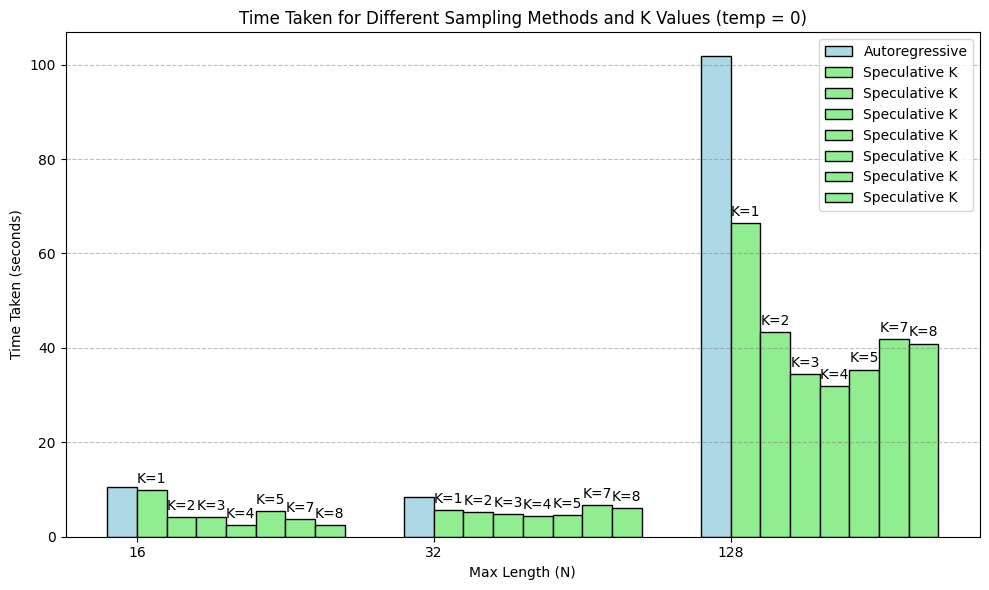

In [76]:
# Define the unique N values (Max Length) and K values for lookahead
max_lengths_sorted = sorted(df['Max Length'].unique())
lookahead_ks = sorted(df[df['Sampling Method'] == 'speculative']['K Values'].unique())
ind = np.arange(len(max_lengths_sorted))
bar_width = 0.1


# Adjust the plot aesthetics as per the user's request
fig, ax = plt.subplots(figsize=(10, 6))

# Set the color for the bars
color_speculative = 'lightgreen'  # A more pleasant color for speculative bars
color_autoregressive = 'lightblue'  # A more pleasant color for autoregressive bars

# Iterate over max_lengths and k_values to create bar positions
for i, max_length in enumerate(max_lengths_sorted):
    # Select subset of DataFrame for the current N (Max Length)
    subset = df[df['Max Length'] == max_length]
    
    # Plot bars for autoregressive method
    autoregressive_time = subset[subset['Sampling Method'] == 'autoregressive']['Time Taken'].values
    if autoregressive_time.size > 0:
        ax.bar(ind[i] - bar_width/2, autoregressive_time, bar_width, label='Autoregressive' if i == 0 else "", 
               color=color_autoregressive, edgecolor='black')
    
    # Plot bars for speculative method with different K values
    speculative_subset = subset[subset['Sampling Method'] == 'speculative']
    for j, k_value in enumerate(speculative_subset['K Values']):
        time = speculative_subset[speculative_subset['K Values'] == k_value]['Time Taken'].values
        if time.size > 0:
            bar = ax.bar(ind[i] + (j+0.5)*bar_width, time, bar_width, label=f'Speculative K' if i == 0 else "", 
                         color=color_speculative, edgecolor='black')
            # Annotate K value on the bar
            ax.annotate(f'K={k_value}',
                        xy=(bar[0].get_x() + bar[0].get_width() / 2, bar[0].get_height()),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

# Add grid to the plot with reduced alpha for less bold lines
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)

# Set the labels and legend
ax.set_xticks(ind)
ax.set_xticklabels(max_lengths_sorted)
ax.set_xlabel('Max Length (N)')
ax.set_ylabel('Time Taken (seconds)')
ax.set_title(f'Time Taken for Different Sampling Methods and K Values (temp = {temperature})')
ax.legend()

# Show the plot
plt.tight_layout()

# Save the plot to a file
plot_file_path = f'bar-plot-sampling-times-temp{temperature}.png'
plt.savefig(plot_file_path)
plt.show()

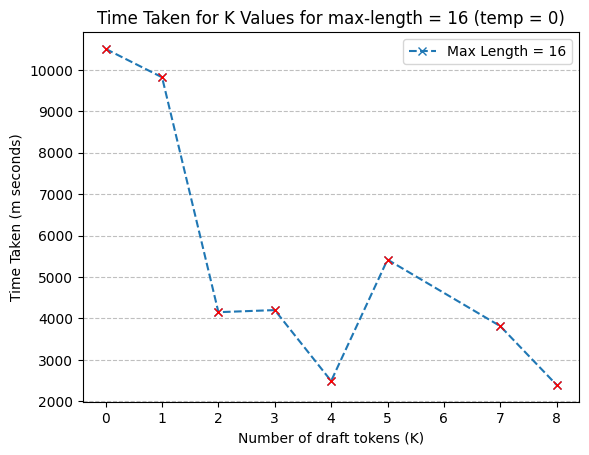

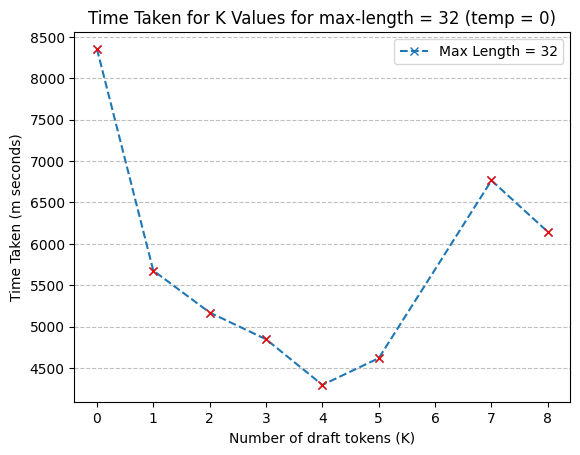

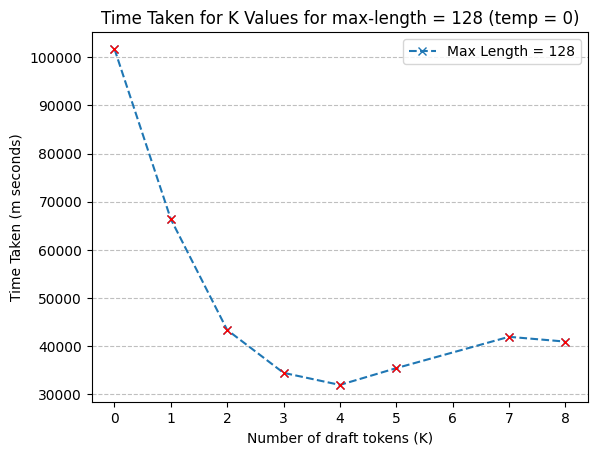

In [77]:
max_lengths_sorted = sorted(df['Max Length'].unique())

for max_length in max_lengths_sorted:
    k = df[df['Max Length'] == max_length]['K Values']
    time_list = df[df['Max Length'] == max_length]['Time Taken'] * 1000
    plt.figure(figsize=(10, 6))
    plt.plot(k, time_list, label=f"Max Length = {max_length}", linestyle='--', marker='x')
    plt.plot(k, time_list, 'x', color='red')

    plt.grid(True, axis='y', linestyle='--', which='major', color='grey', alpha=0.5)
    plt.xlabel('Number of draft tokens (K)')
    plt.ylabel('Time Taken (m seconds)')
    plt.title(f'Time Taken for K Values for max-length = {max_length} (temp = {temperature})')
    plt.legend()
    plt.savefig(f'time-taken-max-length-{max_length}.png')
    plt.show()
    plt.clf()